In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

## Project Goal

The goal of this analysis is to create a model to predict the best fantasy lineup for a certain game using only the statistics of the games previously played in the season as inputs. Whilst the logic for the model is created by analyzing various season progressions, the model itself can only use player histories from the start of the season in which the game to be predicted is in.

Each lineup consists of 8 players: 2 guards, 2 forwards/centers, 2 utility players (guards, forwards, or centers), and 2 bench players (players with no start position but have played more than 0 minutes in the season to date).

The aim is to select a lineup that optimizes fantasy points. For each run of the model, there is a random scoring matrix instantiated that appends a certain number of points to a selected number of player statistics. There are 18 potential statistics than can be incorporated into the scoring matrix, such as rebounds ('reb'), points ('pts'), blocks ('blk'), and so on. 

Given that the system starts with no historical data and continues to learn from game-to-game statistics, it seemingly does not make sense to create a complex model, whether that be parametric or non-parametric. If any form of even a regression was used, the model would most likely output uninformed results for the first half of the season, given the minimal data input. Additionally, it would involve game-by-game tuning of the parameters, which goes against the intent of drop-in usability - the model should be able to perform at any point in the season with any team. 


## Exploratory Data Analysis

To initially explore the data, I will be reviewing the 2017 NBA Season. 

#### Data Preparation

In [2]:
SEASON = 2017

SCORING_MATRIX = {
    'fg3m': 5,
    'reb': 7,
    'ast': 10,
    'stl': 2,
    'blk': 3,
    'pts': 7
}

# Import Data
games = pd.read_csv('games.csv')
games_ = pd.read_csv('games_details.csv')

# Clean
games_.fillna(0, inplace=True)
games_ = games_.merge(games[['GAME_ID','SEASON']])

# Filter Relevant Season
games_details = games_[games_['SEASON'] == SEASON]

#### Ordinal Review 
Given the ordinal nature of the project goal, it is pertinent to ensure that the game IDs are in date order. 

In [3]:
### Review order of game_ids - ***ordered properly
#games[['GAME_DATE_EST', 'GAME_ID']].sort_values(by='GAME_ID').head(20)

#### Position-Specific Stat Contribution
I'm curious to see whether there are stark differences between the best performing statistic per position. As seen below, the balance of points across the stats for each player seems to be in line, with the exception of rebounds for centers. 

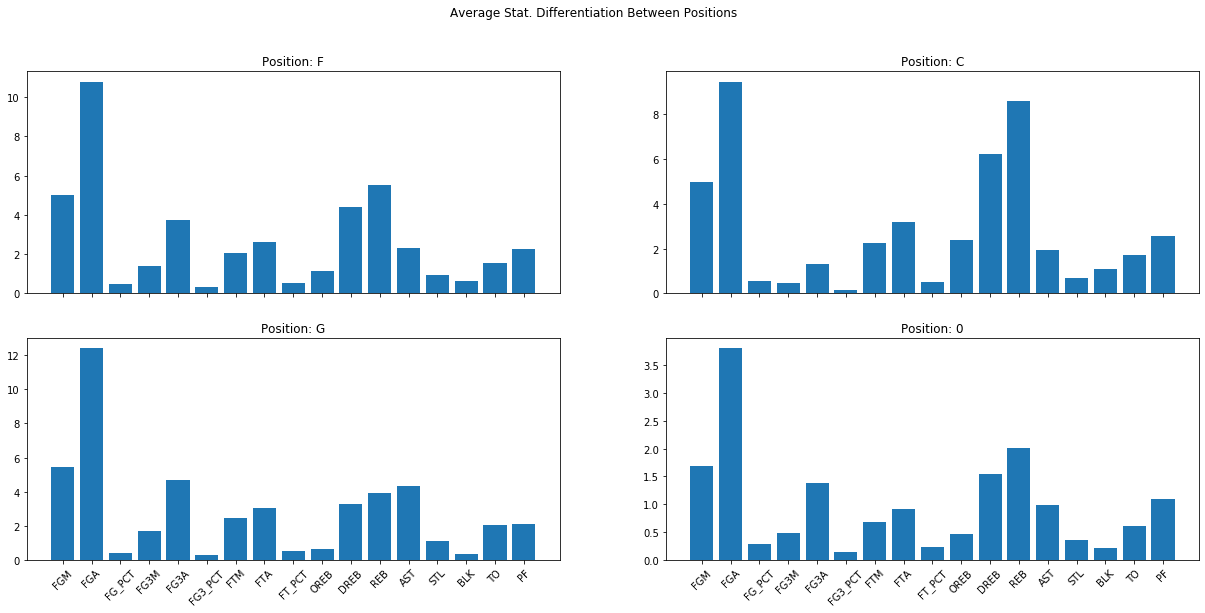

In [4]:
# Remove NaN Stats
games_df = games_details.dropna(subset=['MIN','PTS'])

# Find which positions relate to which stats - remove PTS & plus minus
stats = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF']

# Fill in bench players, get positions
games_df.START_POSITION.fillna('B', inplace=True)
pos = list(games_df.START_POSITION.unique())

#### Get averages for each player
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21,9), sharex=True, sharey=False)
fig.suptitle('Average Stat. Differentiation Between Positions')
for i, ax in enumerate(axes.flatten()):
    stat_means = []
    for stat in stats:
        df = games_df[games_df.START_POSITION==pos[i]]
        stat_means.append(df[stat].mean())
    ax.bar(x=stats, height=stat_means)
    ax.set_title('Position: {}'.format(pos[i]))
    ax.set_xticklabels(labels = stats, rotation=45)
plt.show()

#### Seasonality Trends
It seems necessary to look into seasonality trends across stats and overall points for all teams. My goal is to see if there are standardized spikes for all teams at the same points during the season, as that could inform some sort of weightage moving forward. As seen in the two plots below, teams seem generally even in the minor-stats across the board, with spikes in the overall points coming at different points in the season. 

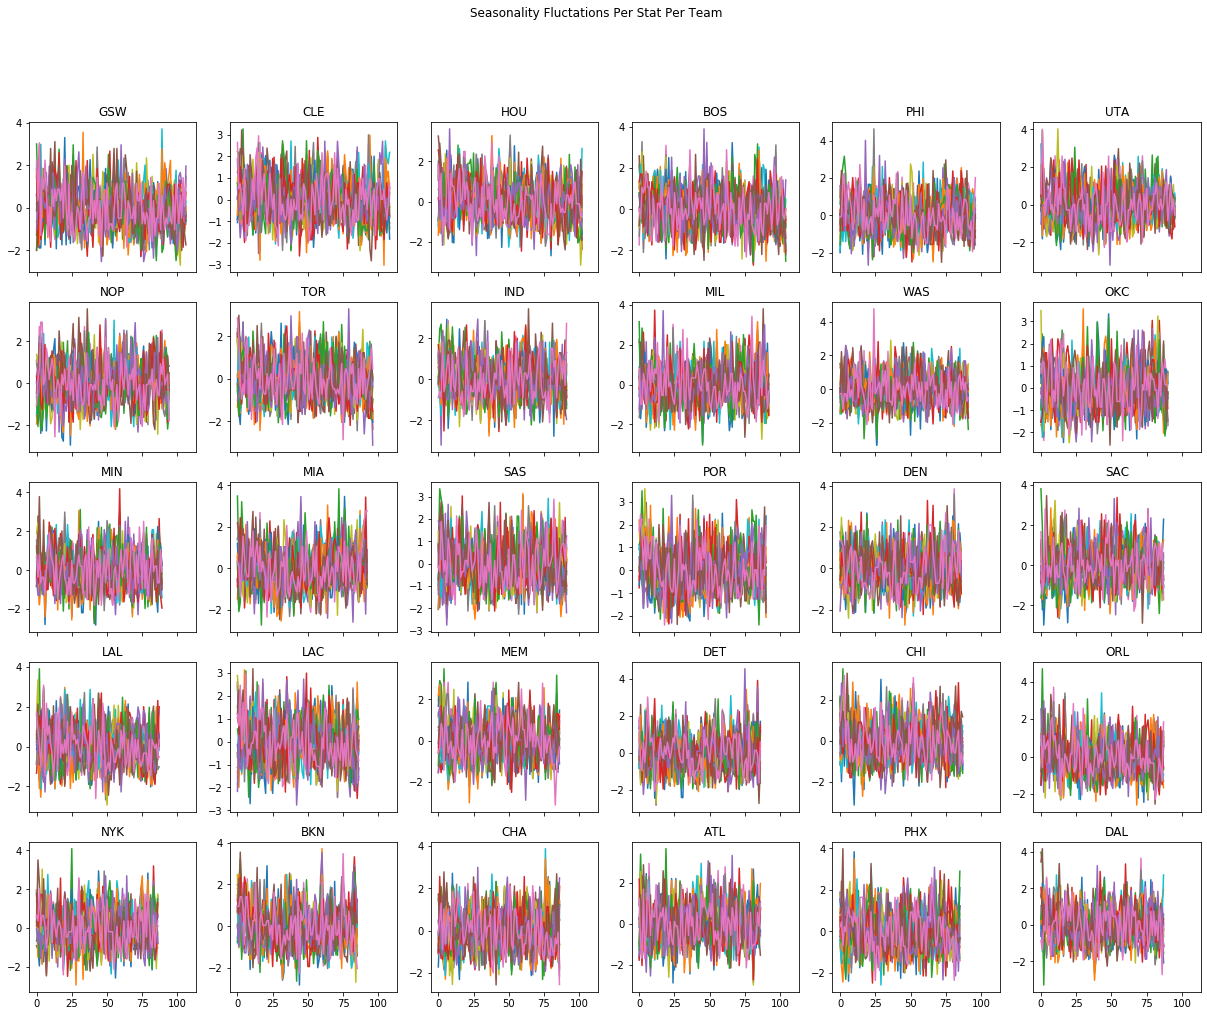

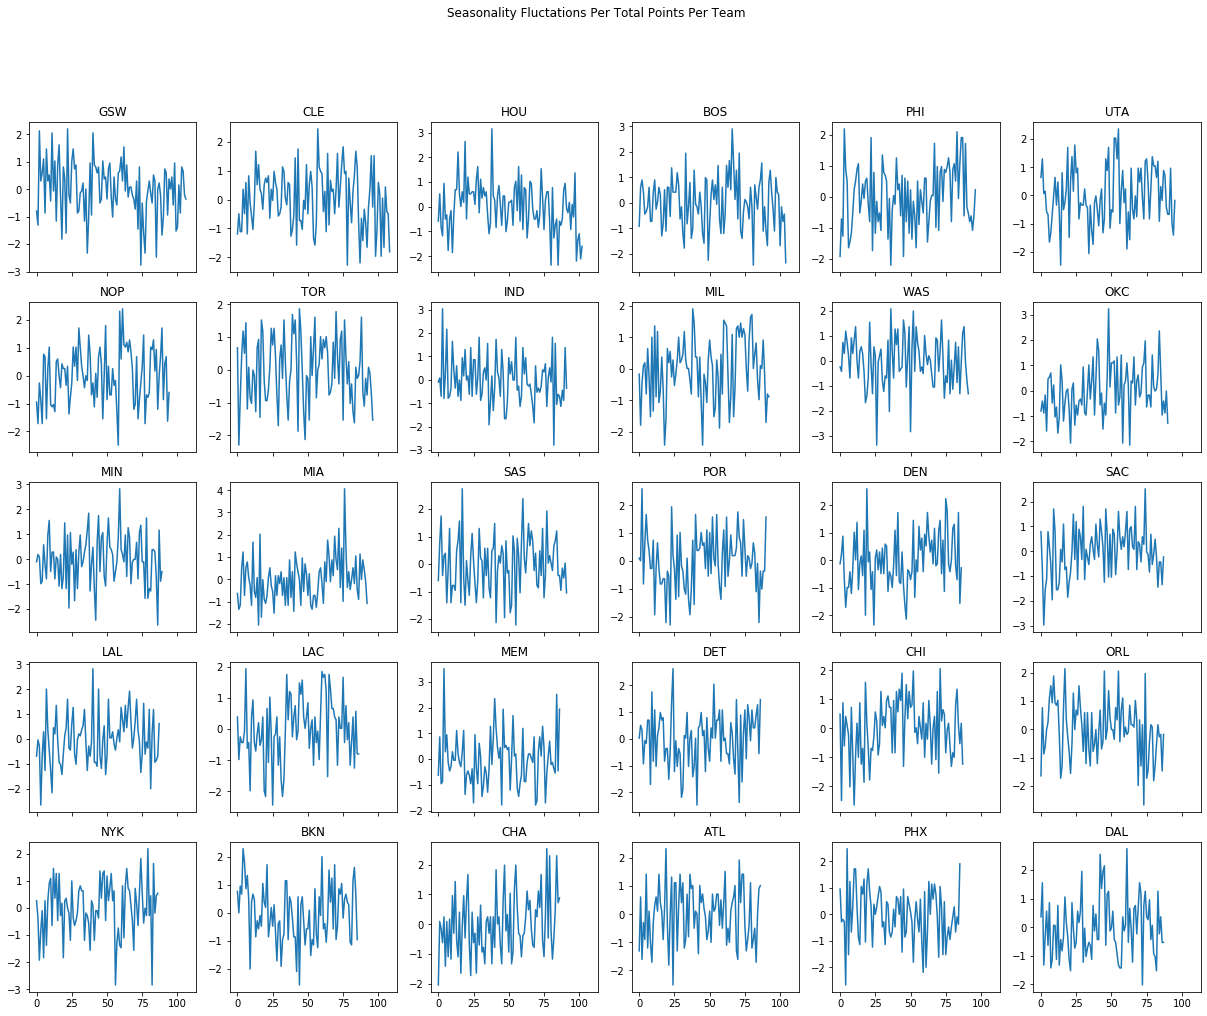

In [5]:
# Plot season averages per team - all stats
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(21,16), sharex=True, sharey=False)
fig.suptitle('Seasonality Fluctations Per Stat Per Team')
teams = games_df.TEAM_ABBREVIATION.unique().tolist()
for i, ax in enumerate(axes.flatten()):
    df = games_df[games_df.TEAM_ABBREVIATION==teams[i]]
    for stat in stats:
        lst = np.array(list(df.groupby('GAME_ID')[stat].sum())).reshape(-1, 1)
        lst = StandardScaler().fit_transform(lst)
        ax.plot(range(0,len(lst)), lst)
    ax.set_title(teams[i])
plt.show()

# Plot season averages per team - total points
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(21,16), sharex=True, sharey=False)
fig.suptitle('Seasonality Fluctations Per Total Points Per Team')
teams = games_df.TEAM_ABBREVIATION.unique().tolist()
for i, ax in enumerate(axes.flatten()):
    df = games_df[games_df.TEAM_ABBREVIATION==teams[i]]
    lst = np.array(list(df.groupby('GAME_ID')['PTS'].sum())).reshape(-1, 1)
    lst = StandardScaler().fit_transform(lst)
    ax.plot(range(0,len(lst)), lst)
    ax.set_title(teams[i])
plt.show()

#### Point Aggregation

My initial assumption was that the simplest way to predict each player's performance per stat would be to calculate their average per min in that statistic to that point, and multiply it by their average minutes played. While this would empirically make sense, there are countless decisions and factors that influence a player's performance, in addition to their performance either getting better or worse as the season progresses.

With this in mind, I performed an analysis to compare a range of rolling window averages to the player's performance in each subsequent game. The method takes in a rolling window from 1-20, calculates the player's average using said window (computes the average of the last x games; if less than x games have been played, computes the average of all previous), and calculates the mean squared error for all players using that window compared to their true scores. Below, I have tested this out on just those in the guard position.

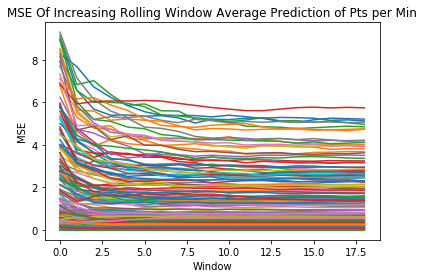

In [6]:
###### Rolling Averages

# 1. Create DF for all teams
# Remove NaN Stats
rolling_df = games_details.dropna(subset=['MIN','PTS'])
# Remove 0 Mins Played
rolling_df = rolling_df[rolling_df.MIN != 0]
# Convert Min to Num
rolling_df['MIN'] = [int(z[0])+int(z[1])/60 for z in [x.split(':') for x in rolling_df['MIN']]]
# Input Bench
rolling_df['START_POSITION'] = rolling_df['START_POSITION'].fillna('B')
rolling_df['START_POSITION'] = rolling_df['START_POSITION'].replace(0,'B')
# Lower Cols to Match
rolling_df.columns = rolling_df.columns.str.lower()
# Create Pts Per Min
rolling_df['pts_min']=rolling_df['pts']/rolling_df['min']
# Sort Game IDs
rolling_df.sort_values(by='game_id', inplace=True)
# Filter Cols
rolling_df = rolling_df[['game_id', 'team_abbreviation','player_name', 'start_position', 'pts_min', 'min']]

# 2. Visualize - For Time, Review Guards Only
games_df = rolling_df
games_df = games_df[games_df.start_position.isin(['G'])]
# Plot
for player in games_df.player_name.unique().tolist():
    df_p = games_df[games_df.player_name==player]
    for i in range(1,20):
        df_p['SMA{}'.format(i)] = df_p['pts_min'].rolling(window=i, min_periods=1).mean().shift() 
    MSE = []
    for col in [x for x in df_p.columns if x.startswith('SMA')]:
        dz = df_p[['pts_min', col]]
        dz.dropna(subset=[col], inplace=True)
        dz['sqr_err'] = (dz.pts_min-dz[col])**2
        MSE.append(dz.sqr_err.sum().mean())
    # Plot
    plt.plot(range(len(MSE)), MSE)
plt.title('MSE Of Increasing Rolling Window Average Prediction of Pts per Min')
plt.xlabel('Window')
plt.ylabel('MSE')
plt.show()

As seen above, there seems to be a steep drop in many stats between window sizes of 2 and 5. Though there are over 70 games played in a season, I wanted to keep the window values low as to compare to a full running average in scores that will be conducted further on into this analysis.

Given that the error does decrease with a specific window, I wanted to find the minimum squared error per stat per position and use that specific window when creating the model. As this is computationally intensive, I found the optimized windows for minutes played and total points only. As seen in a post-run summary below, for all positions between the two stats, the ranges per team fell around window=5. 

In [7]:
# 3. Get Min MSE Windows Per Position (for points)
##### Create Method, Taking In Team, Position, Output Team Dict of Min Window MSE
def team_window_finder(rolling_df, team, position, stat):
    # Dct
    min_mses = []
    # Filter by Position & Team
    games_df = rolling_df[(rolling_df.start_position.isin(position)) & (
        rolling_df.team_abbreviation==team)]
    # Filter By Player
    for player in games_df.player_name.unique().tolist():
        df_p = games_df[games_df.player_name==player]
        # Instantiate # Rolling Windows
        for i in range(1,20):
            df_p['SMA{}'.format(i)] = df_p[stat].rolling(window=i, min_periods=1).mean().shift() 
            MSE = []
            # Calc MSE Per Rolling Window
            for col in [x for x in df_p.columns if x.startswith('SMA')]:
                dz = df_p[[stat, col]]
                dz.dropna(subset=[col], inplace=True)
                dz['sqr_err'] = (dz[stat]-dz[col])**2
                MSE.append(dz.sqr_err.sum().mean())
            # Dict
            mse_dct = dict(zip(range(1,len(MSE)), MSE))
            min_ = [k for k,v in mse_dct.items() if v==min(mse_dct.values())]
            if len(min_)==0:
                pass
            else:
                min_mses.append(np.mean(min_))    
    return np.mean(min_mses)

def position_dct(df, position, stat):
    dct = {}
    for team in df.team_abbreviation.unique().tolist():
        min_win = team_window_finder(rolling_df, team=team, position= position, stat=stat)
        dct.update({team:min_win})
    return dct


### Create Dicts Per Position for Total Points
guards = ['G']
forward_center = ['F','C']
utils = ['G', 'F','C']
bench = ['B']

# Apply
#guard_pts_mse = position_dct(rolling_df, guards, 'pts_min')
#fc_pts_mse = position_dct(rolling_df, forward_center, 'pts_min')
#util_pts_mse = position_dct(rolling_df, utils, 'pts_min')
#bench_pts_mse = position_dct(rolling_df, bench, 'pts_min')

# Means Per MSE
#guard_pts_mse_mean = np.mean(list(guard_pts_mse.values()))
#fc_pts_mse_mean = np.mean(list(fc_pts_mse.values()))
#util_pts_mse_mean = np.mean(list(util_pts_mse.values()))
#bench_pts_mse_mean = np.mean(list(bench_pts_mse.values()))

############# All between 5; Choose 5 For All Points - Time Intensive Run

#guards_min_mse = position_dct(rolling_df, guards, 'min')
#fc_min_mse = position_dct(rolling_df, forward_center, 'min')
#u_min_mse = position_dct(rolling_df, utils, 'min')
#b_min_mse = position_dct(rolling_df, bench, 'min')

#print(np.mean(list(guards_min_mse.values())))
#print(np.mean(list(fc_min_mse.values())))
#print(np.mean(list(u_min_mse.values())))
#print(np.mean(list(b_min_mse.values())))

############# All between 5; Choose 5 For All Mins; Also All Stats - Time Intensive Run

## Model Creation

For the modeling portion, I will be creating two systems: one that uses running overall averages, and one that uses rolling window averages. 

Each model consists of the following methods:

#### 1. Data Filtering (data_filtering)
- As the season is already instantiated in the data import section, this portion further cleans the data to filter by team
- Bench designations are input for those players who have played more than 0 minutes but have no start position


#### 2. History Scoring (history_scoring)
- If this is not the first game of the season:
    - The dataset is filtered to include all data from before the designated game to predict for
    - Each statistic listed in the scoring matrix is converted to stat per min within the historical data
    - Averages for each of those statistics, in addition to minutes played, are then calculated and returned per player per position
         - In BBallAvg: Total average to that point in the season
         - In BBallRolling: Average of previous 5 games played
    - Each statistic listed in the scoring matrix is then multiplied by the output average minutes as the predicted points per stat in the upcoming game
    - Each predicted statistic is then multiplied by the points designated to said statistic within the scoring matrix
    - Per each player and position, total fantasy points as designated by the scoring matrix are returned
- If this is the first game of the season:
    - Total fantasy points per player = 0
        

#### 3. Lineup Creation (lineup_creation)
- Using the total points from the History Scoring section, the two highest point-getters per position category are added to the lineup
- Running list of player names created to not include the same player in a separate position
    

#### 4. Score Prediction (score_pred)
- Using only the names and positions in the lineup, the data is filtered on the real points scored in the game to predict for
- Each player's stat is multiplied by it's fantasy point designation, and all points are summed for total fantasy points
    
    
#### 5. Real Optimal Lineup (real_best_score)
- Used for model testing
- Find the true optimal lineup from the game to predict for; return fantasy points 

Each class is listed out below. 

#### Class 1: Overall Running Average 

In [8]:
class BBallAvg:
    
    def __init__(self, team, num_games):
        self.team = team
        self.num_games = num_games
        self.guards = ['G']
        self.forward_center = ['F','C']
        self.utils = ['G', 'F','C']
        self.bench = ['B']
        self.positions = [self.guards, self.forward_center, self.utils, self.bench]
        self.pos_titles = ['G', 'F/C', 'U', 'B']

    def data_filtering(self):
        # Remove NaN Stats
        games_df = games_details.dropna(subset=['MIN','PTS'])
        # Remove 0 mins played
        games_df = games_df[games_df.MIN != 0]
        # Convert Min to Num
        games_df.MIN = [int(z[0])+int(z[1])/60 for z in [x.split(':') for x in games_df.MIN]]
        # Team Filtering
        games_df = games_df[games_df.TEAM_ABBREVIATION==self.team]
        # Input Bench
        games_df['START_POSITION'] = games_df['START_POSITION'].fillna('B')
        games_df['START_POSITION'] = games_df['START_POSITION'].replace(0,'B')
        # Lower Cols to Match
        games_df.columns = games_df.columns.str.lower()
        return games_df
    
    def history_scoring(self):
        # Call filter method
        df = self.data_filtering()
        # If first game
        if self.num_games == 0:
            # Filter first game to show possible players 
            df = df[df.game_id == sorted(df.game_id.unique().tolist())[0]]
            # Create sum cols
            df['pts_sum'] = 0
        # Else
        else:
            # Filter games before only
            df = df[df.game_id < sorted(df.game_id.unique().tolist())[self.num_games]]
            # Filter by scoring matrix; lower & match
            df.columns = df.columns.str.lower()
            # Create df with averages per stat in scoring matrix
            df = pd.DataFrame(df.groupby(['player_name', 'start_position']).apply(
                lambda x: x[[x for x in list(list(SCORING_MATRIX.keys()))]].sum()/x['min'].sum())).reset_index()
            # Multiply by scores
            for stat,val in SCORING_MATRIX.items():
                df[stat] = df[stat]*val
            # Create sum cols
            df['pts_sum'] = df[SCORING_MATRIX.keys()].sum(axis=1)
        return df
  
    def lineup_creation(self):
        # Call filter method
        df = self.history_scoring()
        # Create lists/dicts  
        line_up = {}
        in_line = []
        for ix in range(len(self.positions)):
            # Get highest average pts/min
            players = df[(~df.player_name.isin(in_line)) & (df.start_position.isin(self.positions[ix]))].sort_values(
                by='pts_sum', ascending=False).player_name.unique().tolist()[0:2]
            # Append to dict
            line_up[self.pos_titles[ix]] = players
            # Append to running list
            in_line.extend(players)
        return line_up
    
    def score_pred(self):
        df = self.data_filtering()
        lineup = self.lineup_creation()
        # Filter game of
        df = df[df.game_id == sorted(df.game_id.unique().tolist())[self.num_games]]
        # Filter by scoring matrix; lower & match
        df.columns = df.columns.str.lower()
        # Multiply by scores
        for stat,val in SCORING_MATRIX.items():
            df[stat] = df[stat]*val
        # Create sum cols
        df['pts_sum'] = df[SCORING_MATRIX.keys()].sum(axis=1)
        # Get predicted points
        pred_sum = []
        # Get points
        for ix in range(len(self.positions)):
            for player in lineup[self.pos_titles[ix]]:
                points = list(df[(df.player_name== player) & (df.start_position.isin(self.positions[ix]))]['pts_sum'])
                if not points:
                    pass
                else:
                    pred_sum.append(float(points[0]))
        # Return output
        return sum(pred_sum)
    
    def real_best_score(self):
        df = self.data_filtering()
        # Filter game of
        df = df[df.game_id == sorted(df.game_id.unique().tolist())[self.num_games]]
        # Multiply by scores
        for stat,val in SCORING_MATRIX.items():
            df[stat] = df[stat]*val
        # Create sum cols
        df['pts_sum'] = df[SCORING_MATRIX.keys()].sum(axis=1)
        # Create lists/dicts  
        real_pts = []
        in_line = []
        for ix in range(len(self.positions)):
            # Get highest average pts/min
            # Player
            players = df[(~df.player_name.isin(in_line)) & (df.start_position.isin(self.positions[ix]))].sort_values(
                by='pts_sum', ascending=False).player_name.unique().tolist()[0:2]
            # Points
            points = df[(~df.player_name.isin(in_line)) & (df.start_position.isin(self.positions[ix]))].sort_values(
                by='pts_sum', ascending=False).pts_sum.unique().tolist()[0:2]
            # Append to running list
            in_line.extend(players)
            real_pts.extend(points)
        return sum(real_pts)

#### Class 2:  Rolling Average 

In [9]:
class BBallRolling:
    
    def __init__(self, team, num_games):
        self.team = team
        self.num_games = num_games
        self.guards = ['G']
        self.forward_center = ['F','C']
        self.utils = ['G', 'F','C']
        self.bench = ['B']
        self.positions = [self.guards, self.forward_center, self.utils, self.bench]
        self.pos_titles = ['G', 'F/C', 'U', 'B']

    def data_filtering(self):
        # Remove NaN Stats
        games_df = games_details.dropna(subset=['MIN','PTS'])
        # Remove 0 mins played
        games_df = games_df[games_df.MIN != 0]
        # Convert Min to Num
        games_df.MIN = [int(z[0])+int(z[1])/60 for z in [x.split(':') for x in games_df.MIN]]
        # Team Filtering
        games_df = games_df[games_df.TEAM_ABBREVIATION==self.team]
        # Input Bench
        games_df['START_POSITION'] = games_df['START_POSITION'].fillna('B')
        games_df['START_POSITION'] = games_df['START_POSITION'].replace(0,'B')
        # Lower Cols to Match
        games_df.columns = games_df.columns.str.lower()
        return games_df
    
    def history_scoring(self):
        # Call filter method
        df = self.data_filtering()
        # If first game
        if self.num_games == 0:
            # Filter first game to show possible players 
            df = df[df.game_id == sorted(df.game_id.unique().tolist())[0]]
            # Create sum cols
            df['pts_sum'] = 0
        # Else
        else:
            # Filter games before only
            df = df[df.game_id < sorted(df.game_id.unique().tolist())[self.num_games]]
            df = df.sort_values(by='game_id')
            # Convert stats to per_min
            for stat in SCORING_MATRIX.keys():
                df[stat]= df[stat]/df['min']
            # Extract cols
            cols = ['game_id','player_name', 'start_position']
            stats = list(SCORING_MATRIX.keys())
            stats.append('min')
            df = df[cols+stats]
            # Create new df with player,pos grouped
            df1 = pd.DataFrame(df.groupby(['player_name', 'start_position'])['min'].sum()).reset_index()
            # Get rolling averages
            for stat_per_min in stats:
                df1[stat_per_min] = pd.Series(df.groupby(['player_name', 'start_position'])[stat_per_min].rolling(
                    window=5, min_periods=1).mean().shift()).reset_index().groupby(
                    ['player_name', 'start_position'])[stat_per_min].tail(1).reset_index(drop=True)
                if stat_per_min == 'min':
                    pass
                else:
                    df1[stat_per_min] = df1[stat_per_min]*df1['min']
            # Multiply by scores
            for stat,val in SCORING_MATRIX.items():
                df1[stat] = df1[stat]*val
            # Create sum cols
            df1['pts_sum'] = df1[SCORING_MATRIX.keys()].sum(axis=1)
            df = df1
        return df
    
    def lineup_creation(self):
        # Call filter method
        df = self.history_scoring()
        # Create lists/dicts  
        line_up = {}
        in_line = []
        for ix in range(len(self.positions)):
            # Get highest average pts/min
            players = df[(~df.player_name.isin(in_line)) & (df.start_position.isin(self.positions[ix]))].sort_values(
                by='pts_sum', ascending=False).player_name.unique().tolist()[0:2]
            # Append to dict
            line_up[self.pos_titles[ix]] = players
            # Append to running list
            in_line.extend(players)
        return line_up
    
    def score_pred(self):
        df = self.data_filtering()
        lineup = self.lineup_creation()
        # Filter game of
        df = df[df.game_id == sorted(df.game_id.unique().tolist())[self.num_games]]
        # Filter by scoring matrix; lower & match
        df.columns = df.columns.str.lower()
        # Multiply by scores
        for stat,val in SCORING_MATRIX.items():
            df[stat] = df[stat]*val
        # Create sum cols
        df['pts_sum'] = df[SCORING_MATRIX.keys()].sum(axis=1)
        # Get predicted points
        pred_sum = []
        # Get points
        for ix in range(len(self.positions)):
            for player in lineup[self.pos_titles[ix]]:
                points = list(df[(df.player_name== player) & (df.start_position.isin(self.positions[ix]))]['pts_sum'])
                if not points:
                    pass
                else:
                    pred_sum.append(float(points[0]))
        # Return output
        return sum(pred_sum)
    
    def real_best_score(self):
        df = self.data_filtering()
        # Filter game of
        df = df[df.game_id == sorted(df.game_id.unique().tolist())[self.num_games]]
        # Multiply by scores
        for stat,val in SCORING_MATRIX.items():
            df[stat] = df[stat]*val
        # Create sum cols
        df['pts_sum'] = df[SCORING_MATRIX.keys()].sum(axis=1)
        # Create lists/dicts  
        real_pts = []
        in_line = []
        for ix in range(len(self.positions)):
            # Get highest average pts/min
            # Player
            players = df[(~df.player_name.isin(in_line)) & (df.start_position.isin(self.positions[ix]))].sort_values(
                by='pts_sum', ascending=False).player_name.unique().tolist()[0:2]
            # Points
            points = df[(~df.player_name.isin(in_line)) & (df.start_position.isin(self.positions[ix]))].sort_values(
                by='pts_sum', ascending=False).pts_sum.unique().tolist()[0:2]
            # Append to running list
            in_line.extend(players)
            real_pts.extend(points)
        return sum(real_pts)

## Model Comparison & Evaluation

To compare the two models, predicted score outputs are plotted below for the first 70 games of the season with 9 different teams. Additionally, the real optimized lineup output score is included to compare. 

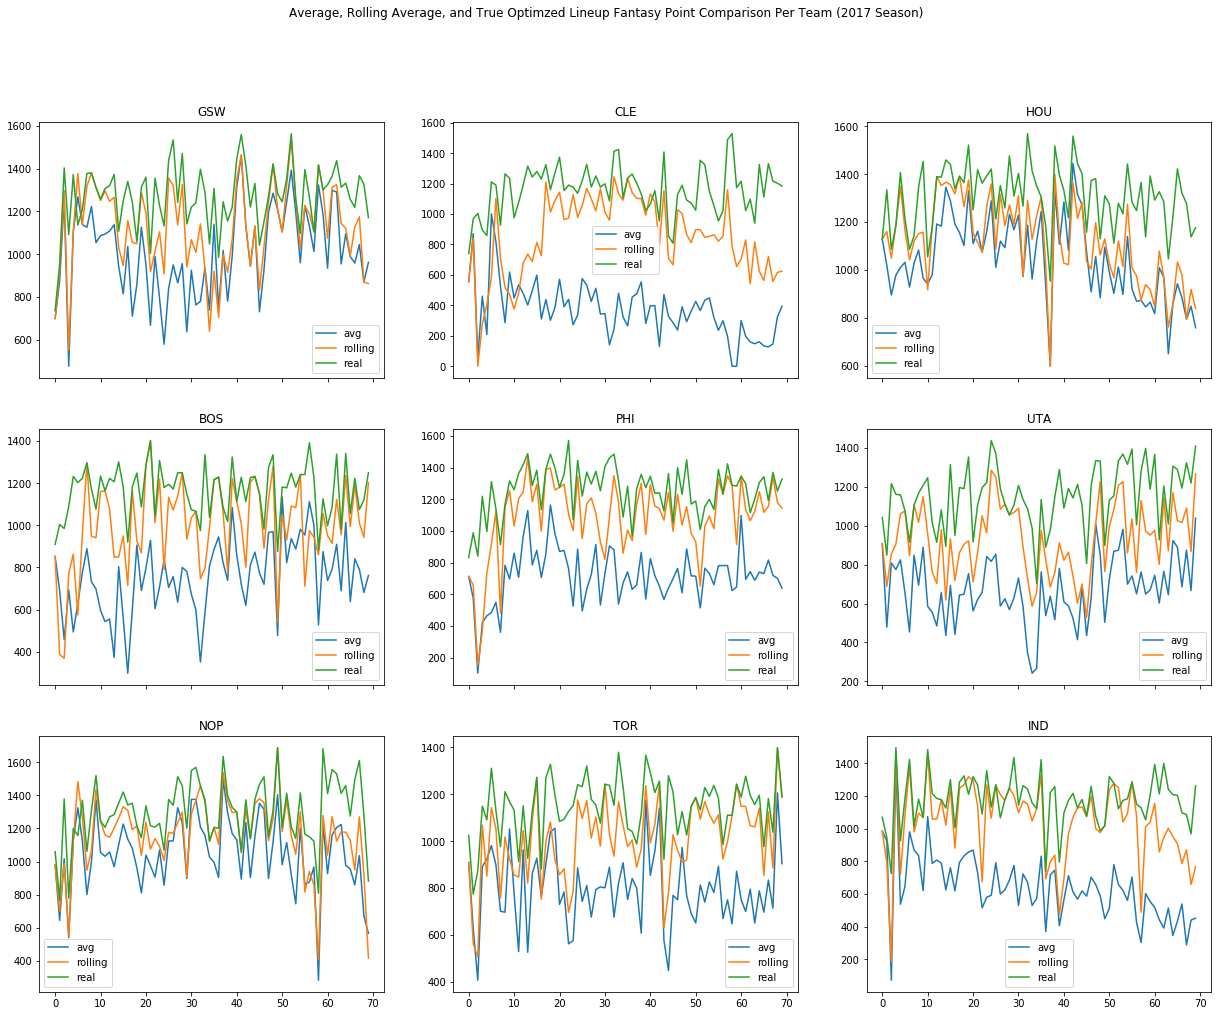

In [10]:
SEASON = 2017

SCORING_MATRIX = {
    'fg3m': 5,
    'reb': 7,
    'ast': 10,
    'stl': 2,
    'blk': 3,
    'pts': 7
}

# Filter Relevant Season
games_details = games_[games_['SEASON'] == SEASON]

# Visualize
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(21,16), sharex=True, sharey=False)
fig.suptitle('Average, Rolling Average, and True Optimzed Lineup Fantasy Point Comparison Per Team (2017 Season)')
teams = games_details.TEAM_ABBREVIATION.unique().tolist()[0:9]

for i, ax in enumerate(axes.flatten()):
    team = teams[i]
    games = range(0,70)

    avg = []
    rolling = []
    real = []

    for game in games:
        avgModel = BBallAvg(team, game)
        rollingModel = BBallRolling(team, game)
    
        avg.append(avgModel.score_pred())
        rolling.append(rollingModel.score_pred())
        real.append(rollingModel.real_best_score())

    ax.plot(avg)
    ax.plot(rolling)
    ax.plot(real)
    ax.legend(['avg', 'rolling', 'real'])
    ax.set_title(team)
plt.show()

As seen above in the 9 selected teams for the 2017 season, the rolling model does generally outperform the average model. While in some instances the average model does to slightly better than the rolling (around game 40 in Houston), the rolling model overall does much better, especially with certain teams (e.g. Cleveland). Additionally, the rolling model seems quite in line with the real best optimized lineup, often taking the same shape, and periodically resulting in equal point totals. 

We can review the same results on the 2018 season with a different scoring matrix. 

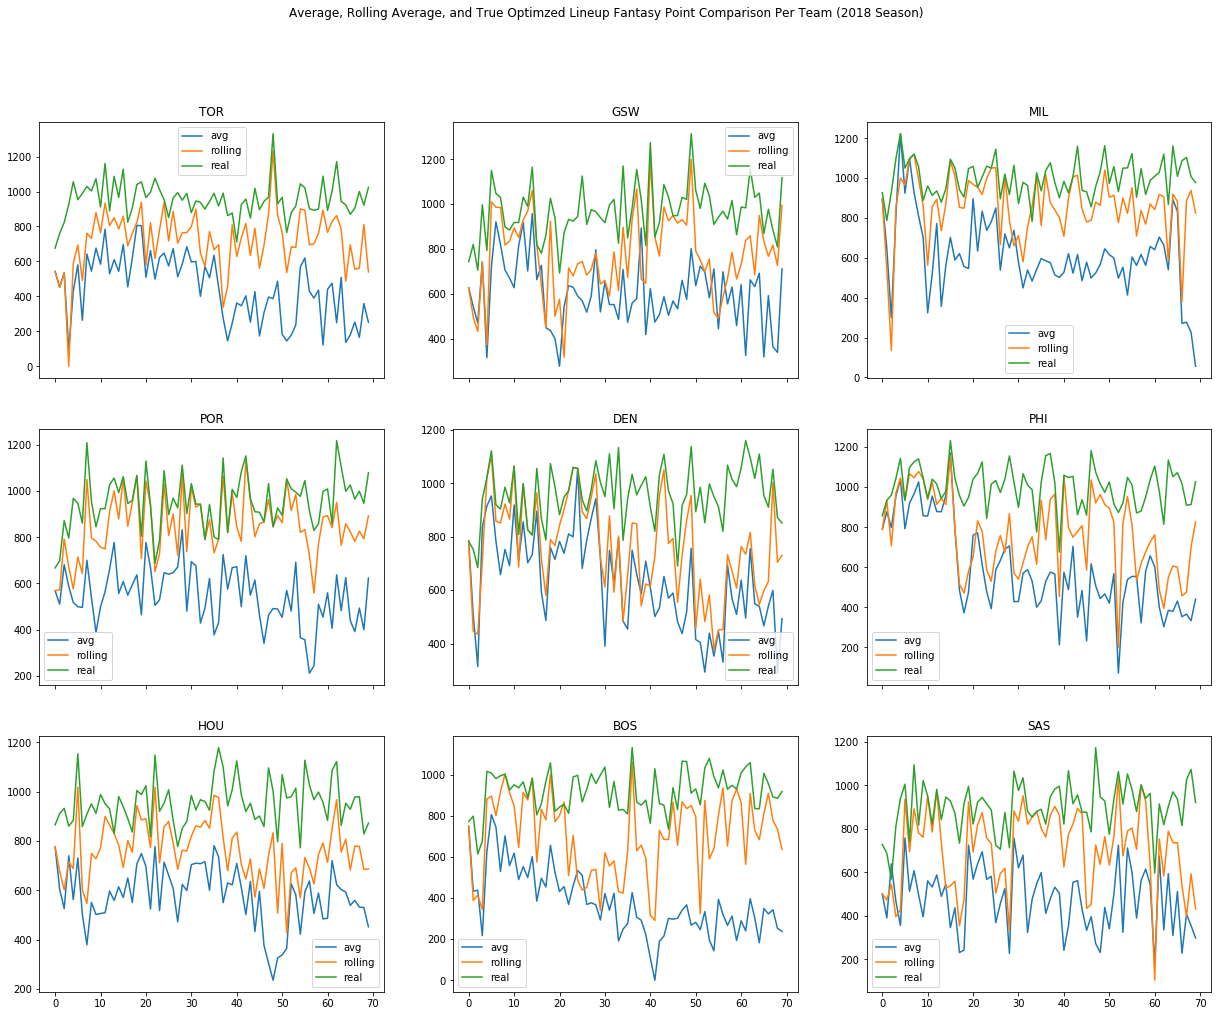

In [11]:
SEASON = 2018

SCORING_MATRIX = {
    'dreb': 8,
    'reb': 7,
    'pf': 9,
    'stl': 3,
    'blk': 3,
    'fgm': 7
}

# Filter Relevant Season
games_details = games_[games_['SEASON'] == SEASON]

# Visualize 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(21,16), sharex=True, sharey=False)
fig.suptitle('Average, Rolling Average, and True Optimzed Lineup Fantasy Point Comparison Per Team (2018 Season)')
teams = games_details.TEAM_ABBREVIATION.unique().tolist()[0:9]

for i, ax in enumerate(axes.flatten()):
    team = teams[i]
    games = range(0,70)

    avg = []
    rolling = []
    real = []

    for game in games:
        avgModel = BBallAvg(team, game)
        rollingModel = BBallRolling(team, game)
    
        avg.append(avgModel.score_pred())
        rolling.append(rollingModel.score_pred())
        real.append(rollingModel.real_best_score())

    ax.plot(avg)
    ax.plot(rolling)
    ax.plot(real)
    ax.legend(['avg', 'rolling', 'real'])
    ax.set_title(team)
plt.show()

Given the results of both models as compared to the true optimized lineup scores, proceeding with the rolling average model seems like the best course.

### Further Work & Limitations

There is no doubt this analysis would be better served with a greater historical understanding of the game, the coaching and real-time lineup decisions made, and each individual position's strengths and weaknesses. Given this, there are certainly additional optimizations that could improve the model.

In continuing this analysis, it would be prudent to test all seasons, teams, and positions, and see if there is any change in window range predictions. Additionally, performing much deeper research on other algorithms and less-complex models used in other fantasy sports could be beneficial in allowing a more exact prediction without having to retrain and test a model after each game.